In [4]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import sys
import os
from tqdm import tqdm  
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim import utils
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
import gensim.downloader as api

# import dlnlputils
# from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
#     vectorize_texts, SparseFeaturesDataset
# from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

# init_random_seed()

In [5]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset

In [6]:
#подготовка признаков

In [7]:
import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def character_tokenize(txt):
    return list(txt)


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]


def add_fake_token(word2id, token=''):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new


def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


PAD_TOKEN = '__PAD__'
NUMERIC_TOKEN = '__NUMBER__'
NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)


def replace_number_nokens(tokenized_texts):
    return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
            for text in tokenized_texts]

In [8]:
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

In [9]:
import pandas as pd
df = pd.read_csv("data/bitkogan.csv")

In [10]:
df = pd.DataFrame([])
for root, dirs, files in os.walk('data'):
    for file in tqdm(files[:1]):
        df1 = pd.read_csv(f'data/{file}')
        df = pd.concat([df, df1], axis=0, ignore_index=True)

df = df.sort_values('date', ignore_index=True)
df.head()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


,id,date,text
0,9,2017-07-28T10:56:14,Cbonds.ru запустило канал в Telegram. Планиру...
1,10,2017-08-03T15:28:17,Облигационный бюллетень Cbonds – все данные о ...
2,11,2017-08-03T15:41:02,Cbonds prepared monthly report: CBONDS GLOBAL ...
3,12,2017-08-03T18:11:32,Дайджест Cbonds от 3 августа:«Группа Компаний...
4,13,2017-08-04T12:42:41,Совкомбанк открыл книгу заявок на вторичное ра...


In [11]:
pnl = pd.read_csv('Backtest_USDRUB_5_days_2022.txt')
pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
pnl

,date_start,pnl,pnl_sign
0,2022-03-02,4.562674e+06,1
1,2022-03-03,-4.663725e+06,0
2,2022-03-04,-4.845276e+05,0
3,2022-03-09,1.268498e+06,1
4,2022-03-10,-2.874466e+06,0
...,...,...,...
138,2022-09-28,-3.886725e+05,0
139,2022-09-29,8.040320e+05,1
140,2022-09-30,1.544311e+06,1
141,2022-10-03,1.868107e+06,1


In [12]:
pnl['pnl_sign'].sum() / pnl.shape[0]

0.32167832167832167

In [13]:
pnl['cumm_text'] = None
pnl

,date_start,pnl,pnl_sign,cumm_text
0,2022-03-02,4.562674e+06,1,None
1,2022-03-03,-4.663725e+06,0,None
2,2022-03-04,-4.845276e+05,0,None
3,2022-03-09,1.268498e+06,1,None
4,2022-03-10,-2.874466e+06,0,None
...,...,...,...,...
138,2022-09-28,-3.886725e+05,0,None
139,2022-09-29,8.040320e+05,1,None
140,2022-09-30,1.544311e+06,1,None
141,2022-10-03,1.868107e+06,1,None


In [14]:
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

In [15]:
df_with_pnl = df[(df['date'] >= '2022-03-01') & (df['date'] <= '2022-10-31')]
df_with_pnl

,id,date,text
9848,10798,2022-03-01,УТРЕННИЙ ДАЙДЖЕСТ 🔹Сегодня торги на Московско...
9849,10799,2022-03-01,​​ 📚 Cbonds Review №1/2022: «Макроэкономика. И...
9850,10800,2022-03-01,⚡️ Важное на рынках: 🇰🇿⛔️На Казахстанской фонд...
9851,10802,2022-03-01,#ДенежныйРынок 📆💰 События денежного рынка сего...
9852,10803,2022-03-01,🔜 ⏯ Провайдер индекса MSCI назвал исключение...
...,...,...,...
11951,13076,2022-10-31,​​ #РейтингиСНГ 🗂 Присвоение / Изменение рейт...
11952,13077,2022-10-31,​​ ✔️ Рейтинги компаний от агентства SNS Ratin...
11953,13078,2022-10-31,⌛️ Последний шанс принять участие в Cbonds Awa...
11954,13079,2022-10-31,#Премаркетинг ⚒ «Южуралзолото Группа Компаний...


In [16]:
i = 0
texts = ''
for _, row in df_with_pnl.iterrows():
    if i >= pnl.shape[0]:
        break

    if row['date'] <= pnl['date_start'][i]:
        texts += ' ' + row['text']
    else:
        pnl.at[i, 'cumm_text'] = texts
        texts = ''
        i += 1
        continue

pnl.head()

,date_start,pnl,pnl_sign,cumm_text
0,2022-03-02,4.562674e+06,1,УТРЕННИЙ ДАЙДЖЕСТ 🔹Сегодня торги на Московск...
1,2022-03-03,-4.663725e+06,0,⚡️Важное на рынках: 🏛Банк России до конца год...
2,2022-03-04,-4.845276e+05,0,"⚡️Важное на рынках: 🏛💵Банк России, дополнител..."
3,2022-03-09,1.268498e+06,1,#РейтингиМир 📊 Рейтинговые действия в иностра...
4,2022-03-10,-2.874466e+06,0,💻 JPMorgan Chase & Co. отказался от роли кон...


In [17]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(pnl)

In [18]:
train_tokenized = tokenize_corpus(train['cumm_text'])
val_tokenized = tokenize_corpus(val['cumm_text'])

In [19]:
print(' '.join(train_tokenized[0]))

премаркетинг балтийский лизинг млрд книга открыта ориентир ставки купона годовых эффективной доходности годовых организаторами выступают регион global markets газпромбанк синара инвестбанк сегодня рынок ломбардов 2022 прогнозы реалии возможности онлайн семинар cbonds сегодня сентября побеседуем генеральным директором мосгорломбард председателем совета национальное объединение ломбардов алексеем лазутиным ответим важные вопросы почему ломбард древнейший финансовый институт который работает почему ломбард золото которое приносит процентный доход почему ломбард финансовый золотодобытчик почему ломбарды помогают окружающей среде кроме этого разберем основные стратегии участников рынка спикеры онлайн семинара сергей лялин основатель cbonds алексей лазутин генеральный директор мосгорломбард когда сентября участие бесплатное необходима регистрация встречи онлайн семинаре cbonds новостикомпаний российские компании основные события сентября завершается период подачи заявок участие группы позити

In [20]:
# строим словарь - vocabulary с помощью функции build_vocabulary
# принимает на вход список списков токенезированные
# word_doc_freq - содержит относительные частоты всех слов в датасете, он понадобиться 
# на этапе формирования матрицы признаков

MAX_DF = 0.8 #во скольких документах встречаеться слово
MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 3474
[('году', 0), ('евробонды', 1), ('корпоративные', 2), ('источник', 3), ('изменение', 4), ('выпуска', 5), ('размещения', 6), ('рейтинга', 7), ('бумаг', 8), ('странах', 9)]


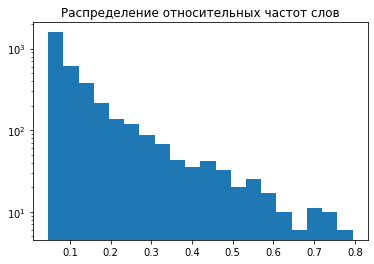

In [21]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [22]:
VECTORIZATION_MODE = 'tfidf'
# построение матрицы признаков по методу мешка слов
# функция vectorize_texts принимает на вход
#1. токенизированные список списков
#2. словарь
#3. вектор частоты токенизированны
#4. алгоритм взвешивания токенов по частоте mode - есть 4 алгорима - bin,tf,idf,tfidf
#5. флаг чтобы перемаштабировать флаг после взвешивания

train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()


Размерность матрицы признаков обучающей выборки (107, 3474)

Количество ненулевых элементов в обучающей выборке 50276
Процент заполненности матрицы признаков 13.53%



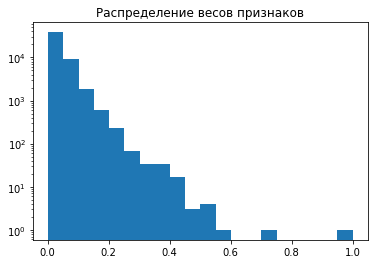

In [23]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [24]:
#word2vec

In [25]:
from gensim.models import Word2Vec

In [26]:
train_vectors

<107x3474 sparse matrix of type '<class 'numpy.float32'>'
	with 50276 stored elements in Compressed Sparse Row format>

In [27]:
import gensim.downloader as api
for k, v in api.info().items():
    for k1, v1 in v.items():
        print(k1)

semeval-2016-2017-task3-subtaskBC
semeval-2016-2017-task3-subtaskA-unannotated
patent-2017
quora-duplicate-questions
wiki-english-20171001
text8
fake-news
20-newsgroups
__testing_matrix-synopsis
__testing_multipart-matrix-synopsis
fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [28]:
model_t1 = api.load('glove-twitter-200')

In [29]:
model_t = api.load('glove-twitter-100')

In [30]:
from gensim import utils

def get_vectors_gt100(row):
    '''
      word_doc_freq # частоты слов
      train_tokenized #сами слова
    '''
    vecs = [np.zeros(100)]
    for word in row:
        #print(row)
        try: 
            # если слово есть в нашем очищенном словаре
            # умножаем вектор на вес tfidf
            v = model_t[word] * word_doc_freq[vocabulary[word]] 
        except:
            v = np.zeros(100)
        vecs.append(v)
    return np.sum(np.array(vecs),axis=0)

In [31]:
train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

In [32]:
train_vectors_gt100, train_vectors_gt100.shape

(array([[  16.61768179,  -10.03980736,  -26.04915971, ...,  -25.36985162,
           13.69807038,    3.70235642],
        [  18.54875058,  -27.73824247,  -55.05477129, ...,  -56.81497441,
           26.02600148,   15.18794308],
        [ 144.84032069, -107.33370965, -240.1143398 , ..., -253.26316217,
           43.94396368,   39.86093081],
        ...,
        [  28.39204341,  -16.26904998,  -50.13582587, ...,  -45.37164751,
           15.33195962,    8.61298143],
        [  35.37980141,  -27.51825461,  -62.45691667, ...,  -80.4435968 ,
           32.62117019,   13.61225518],
        [  21.56485745,  -14.61338575,  -43.40020939, ...,  -49.47137921,
           21.41163269,   11.924793  ]]),
 (107, 100))

In [33]:
model_t1.most_similar(positive=['инвестор', 'рынок'], topn=1)

[('российский', 0.5974039435386658)]

In [34]:
model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

[('аналитик', 0.7176759243011475)]

In [35]:
y_train = train['pnl_sign']
X_train = train_vectors_gt100

y_val = val['pnl_sign']
X_val = val_vectors_gt100

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_val, y_val))
print('данные:', list(os.walk('data/'))[0][-1][:-2])

0.6111111111111112
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv', 'Alfa_Wealth.csv']


In [38]:
model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_val, y_val))
print('данные:', list(os.walk('data/'))[0][-1][:-2])

0.6111111111111112
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv', 'Alfa_Wealth.csv']


In [39]:
from gensim import utils

def get_vectors_gt100(row):
    '''
      word_doc_freq # частоты слов
      train_tokenized #сами слова
    '''
    vecs = [np.zeros(100)]
    for word in row:
        #print(row)
        try: 
            # если слово есть в нашем очищенном словаре
            # умножаем вектор на вес tfidf
            v = model_t[word] * word_doc_freq[vocabulary[word]] 
        except:
            v = np.zeros(100)
        vecs.append(v)
    return np.sum(np.array(vecs),axis=0)

In [40]:
model_t = api.load('glove-twitter-100')

In [42]:
input_path = 'data/' # нужно указать путь до папки с данными по новостям

for root, dirs, files in os.walk(input_path):
    for q in tqdm(range(1, 12)):
        df = pd.DataFrame([])
        for file in files[:q]:
            df1 = pd.read_csv(f'{input_path}/{file}')
            df = pd.concat([df, df1], axis=0, ignore_index=True)

        df = df.sort_values('date', ignore_index=True)
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

        pnl = pd.read_csv('Backtest_USDRUB_5_days.txt')
        pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
        pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
        pnl['cumm_text'] = None

        df_with_pnl = df[(df['date'] >= '2021-01-01') & (df['date'] <= '2021-12-31')]

        i = 0
        texts = ''
        for _,row in df_with_pnl.iterrows():
            if i >= pnl.shape[0]:
                break

            if row['date'] <= pnl['date_start'][i]:
                texts += ' ' + row['text']
            else:
                pnl.at[i,'cumm_text'] = texts
                texts = ''
                i += 1
                continue

        train, val = train_test_split(pnl)
        train_tokenized = tokenize_corpus(train['cumm_text'])
        val_tokenized = tokenize_corpus(val['cumm_text'])

        MAX_DF = 0.8 #во скольких документах встречаеться слово
        MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


        vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
        UNIQUE_WORDS_N = len(vocabulary)    
        VECTORIZATION_MODE = 'tfidf'
        train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

        train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
        val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

        model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

        y_train = train['pnl_sign']
        X_train = train_vectors_gt100

        y_val = val['pnl_sign']
        X_val = val_vectors_gt100

        model = LogisticRegression()
        model.fit(X_train, y_train)
        print(model.score(X_val, y_val))
        print('данные:', files[:q])
        print('всего наблюдений:', df_with_pnl.shape[0])


  9%|████                                        | 1/11 [00:02<00:26,  2.62s/it]

0.5555555555555556
данные: ['cbonds.csv']
всего наблюдений: 3618


 18%|████████                                    | 2/11 [00:04<00:21,  2.42s/it]

0.4126984126984127
данные: ['cbonds.csv', 'themovchans.csv']
всего наблюдений: 3726


 27%|████████████                                | 3/11 [00:07<00:19,  2.38s/it]

0.4603174603174603
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv']
всего наблюдений: 3726


 36%|████████████████                            | 4/11 [00:09<00:16,  2.35s/it]

0.4444444444444444
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv']
всего наблюдений: 3726


 45%|████████████████████                        | 5/11 [00:13<00:17,  2.98s/it]

0.38095238095238093
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv']
всего наблюдений: 7125


 55%|████████████████████████                    | 6/11 [00:17<00:16,  3.36s/it]

0.3968253968253968
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv']
всего наблюдений: 7125


 64%|████████████████████████████                | 7/11 [00:23<00:17,  4.29s/it]

0.47619047619047616
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv']
всего наблюдений: 20494


 73%|████████████████████████████████            | 8/11 [00:29<00:14,  4.74s/it]

0.4444444444444444
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore']
всего наблюдений: 20494


 82%|████████████████████████████████████        | 9/11 [00:36<00:10,  5.30s/it]

0.49206349206349204
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv']
всего наблюдений: 20494


 91%|███████████████████████████████████████    | 10/11 [00:42<00:05,  5.76s/it]

0.38095238095238093
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv']
всего наблюдений: 22043


100%|███████████████████████████████████████████| 11/11 [00:49<00:00,  4.53s/it]

0.4444444444444444
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv', 'Alfa_Wealth.csv']
всего наблюдений: 22218


In [43]:
input_path = 'data/'

for root, dirs, files in os.walk(input_path):
    for q in tqdm(range(1, 12)):
        df = pd.DataFrame([])
        for file in files[:q]:
            df1 = pd.read_csv(f'{input_path}/{file}')
            df = pd.concat([df, df1], axis=0, ignore_index=True)

        df = df.sort_values('date', ignore_index=True)
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

        pnl = pd.read_csv('Backtest_USDRUB_5_days_2022.txt')
        pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
        pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
        pnl['cumm_text'] = None

        df_with_pnl = df[(df['date'] >= '2022-03-01') & (df['date'] <= '2022-12-31')]

        i = 0
        texts = ''
        for _,row in df_with_pnl.iterrows():
            if i >= pnl.shape[0]:
                break

            if row['date'] <= pnl['date_start'][i]:
                texts += ' ' + row['text']
            else:
                pnl.at[i,'cumm_text'] = texts
                texts = ''
                i += 1
                continue

        train, val = train_test_split(pnl)
        train_tokenized = tokenize_corpus(train['cumm_text'])
        val_tokenized = tokenize_corpus(val['cumm_text'])

        MAX_DF = 0.8 #во скольких документах встречаеться слово
        MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


        vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
        UNIQUE_WORDS_N = len(vocabulary)    
        VECTORIZATION_MODE = 'tfidf'
        train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

        train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
        val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

        model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

        y_train = train['pnl_sign']
        X_train = train_vectors_gt100

        y_val = val['pnl_sign']
        X_val = val_vectors_gt100

        model = LogisticRegression()
        model.fit(X_train, y_train)
        print(model.score(X_val, y_val))
        print('данные:', files[:q])
        print('всего наблюдений:', df_with_pnl.shape[0])


  9%|████                                        | 1/11 [00:01<00:19,  1.90s/it]

0.6388888888888888
данные: ['cbonds.csv']
всего наблюдений: 2154


 18%|████████                                    | 2/11 [00:03<00:15,  1.70s/it]

0.6111111111111112
данные: ['cbonds.csv', 'themovchans.csv']
всего наблюдений: 2317


 27%|████████████                                | 3/11 [00:05<00:13,  1.67s/it]

0.4722222222222222
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv']
всего наблюдений: 2456


 36%|████████████████                            | 4/11 [00:06<00:12,  1.76s/it]

0.6111111111111112
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv']
всего наблюдений: 2750


 45%|████████████████████                        | 5/11 [00:09<00:13,  2.20s/it]

0.5833333333333334
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv']
всего наблюдений: 4311


 55%|████████████████████████                    | 6/11 [00:13<00:12,  2.49s/it]

0.5833333333333334
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv']
всего наблюдений: 4476


 64%|████████████████████████████                | 7/11 [00:17<00:12,  3.09s/it]

0.6111111111111112
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv']
всего наблюдений: 13550


 73%|████████████████████████████████            | 8/11 [00:21<00:10,  3.47s/it]

0.6111111111111112
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore']
всего наблюдений: 13550


 82%|████████████████████████████████████        | 9/11 [00:26<00:07,  3.78s/it]

0.6944444444444444
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv']
всего наблюдений: 13550


 91%|███████████████████████████████████████    | 10/11 [00:31<00:04,  4.24s/it]

0.5
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv']
всего наблюдений: 14924


100%|███████████████████████████████████████████| 11/11 [00:37<00:00,  3.37s/it]

0.6944444444444444
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv', 'Alfa_Wealth.csv']
всего наблюдений: 15129


In [44]:
input_path = 'data/'

for root, dirs, files in os.walk(input_path):
    for q in tqdm(range(1, 12)):
        df = pd.DataFrame([])
        for file in files[:q]:
            df1 = pd.read_csv(f'{input_path}/{file}')
            df = pd.concat([df, df1], axis=0, ignore_index=True)

        df = df.sort_values('date', ignore_index=True)
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

        pnl = pd.read_csv('Backtest_USDRUB_5_days_2022.txt')
        pnl['date_start'] = pd.to_datetime(pnl['date_start']).dt.strftime('%Y-%m-%d')
        pnl['pnl_sign'] = pnl['pnl'].apply(lambda x: 1 if x >= 0 else 0)
        pnl['cumm_text'] = None

        df_with_pnl = df[(df['date'] >= '2022-03-01') & (df['date'] <= '2022-10-31')]

        i = 0
        texts = ''
        for _,row in tqdm(df_with_pnl.iterrows()):
            if i >= pnl.shape[0]:
                break

            if row['date'] <= pnl['date_start'][i]:
                texts += ' ' + row['text']
            else:
                pnl.at[i,'cumm_text'] = texts
                texts = ''
                i += 1
                continue

        train, val = train_test_split(pnl)
        train_tokenized = tokenize_corpus(train['cumm_text'])
        val_tokenized = tokenize_corpus(val['cumm_text'])

        MAX_DF = 0.8 #во скольких документах встречаеться слово
        MIN_COUNT = 5 # сколько раз слово встречаеться в тексте


        vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
        UNIQUE_WORDS_N = len(vocabulary)    
        VECTORIZATION_MODE = 'tfidf'
        train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

        train_vectors_gt100 = np.array([get_vectors_gt100(i) for i in train_tokenized])
        val_vectors_gt100 = np.array([get_vectors_gt100(i) for i in val_tokenized])

        model_t.most_similar(positive=['инвестор', 'рынок'], topn=1)

        y_train = train['pnl_sign']
        X_train = train_vectors_gt100

        y_val = val['pnl_sign']
        X_val = val_vectors_gt100

        model = LogisticRegression()
        model.fit(X_train, y_train)
        print(model.score(X_val, y_val))
        print('данные:', files[:q])
        print('всего наблюдений:', df_with_pnl.shape[0])


  0%|                                                    | 0/11 [00:00<?, ?it/s]
1907it [00:00, 43534.91it/s]
  9%|████                                        | 1/11 [00:01<00:15,  1.50s/it]

0.5277777777777778
данные: ['cbonds.csv']
всего наблюдений: 2108



2005it [00:00, 46415.35it/s]
 18%|████████                                    | 2/11 [00:02<00:13,  1.48s/it]

0.5
данные: ['cbonds.csv', 'themovchans.csv']
всего наблюдений: 2259



2122it [00:00, 48419.95it/s]
 27%|████████████                                | 3/11 [00:04<00:11,  1.46s/it]

0.6666666666666666
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv']
всего наблюдений: 2396



2385it [00:00, 47158.56it/s]
 36%|████████████████                            | 4/11 [00:06<00:10,  1.53s/it]

0.7222222222222222
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv']
всего наблюдений: 2685



3740it [00:00, 49358.73it/s]
 45%|████████████████████                        | 5/11 [00:08<00:11,  1.94s/it]

0.4722222222222222
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv']
всего наблюдений: 4213



3894it [00:00, 51576.97it/s]
 55%|████████████████████████                    | 6/11 [00:11<00:10,  2.15s/it]

0.6666666666666666
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv']
всего наблюдений: 4378



0it [00:00, ?it/s]
5424it [00:00, 54232.94it/s]
11777it [00:00, 54219.41it/s]
 64%|████████████████████████████                | 7/11 [00:15<00:10,  2.72s/it]

0.6944444444444444
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv']
всего наблюдений: 13290



0it [00:00, ?it/s]
5392it [00:00, 53917.74it/s]
11777it [00:00, 54104.61it/s]
 73%|████████████████████████████████            | 8/11 [00:19<00:09,  3.12s/it]

0.6111111111111112
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore']
всего наблюдений: 13290



0it [00:00, ?it/s]
5320it [00:00, 53195.23it/s]
11777it [00:00, 52976.98it/s]
 82%|████████████████████████████████████        | 9/11 [00:23<00:06,  3.44s/it]

0.5555555555555556
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv']
всего наблюдений: 13290



0it [00:00, ?it/s]
5107it [00:00, 51066.52it/s]
12996it [00:00, 51308.79it/s]
 91%|███████████████████████████████████████    | 10/11 [00:28<00:03,  3.97s/it]

0.6388888888888888
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv']
всего наблюдений: 14643



0it [00:00, ?it/s]
4817it [00:00, 48164.19it/s]
13171it [00:00, 49609.39it/s][A
100%|███████████████████████████████████████████| 11/11 [00:34<00:00,  3.11s/it]

0.6666666666666666
данные: ['cbonds.csv', 'themovchans.csv', 'headlines_QUANTS.csv', 'War_Wealth_Wisdom.csv', 'mmi.csv', 'vts.csv', 'signal.csv', '.gitignore', 'zgmail.csv', 'rshb_invest.csv', 'Alfa_Wealth.csv']
всего наблюдений: 14842
